# Cats and Dogs
by uramoon@kw.ac.kr<br><br>
고양이와 개를 분류하는 간단한(?) 모델을 만들어봅시다!<br>
런타임 유형은 가급적 GPU로 설정하세요. <br><br>

**Author:** [fchollet](https://twitter.com/fchollet)<br>
**Date created:** 2020/04/15<br>
**Last modified:** 2020/05/12<br>
**Description:** Complete guide to transfer learning & fine-tuning in Keras.<br>
(<a href="https://raw.githubusercontent.com/ronreiter/interactive-tutorials/master/LICENSE">Apache 2.0 License</a>)

In [15]:
import numpy as np
import tensorflow as tf
from tensorflow import keras

## 데이터 가져오기
원래 25,000장의 그림이 있는데 15,000장만 가져와서 그 중 10,000장은 훈련, 2500장은 검증, 2500장은 테스트에 사용하겠습니다.<br>
(오염된 이미지들이 있어서 다 받아오진 못하고 수 백장의 사진이 걸러집니다.)

In [16]:
# 이해하지 않아도 괜찮습니다.

# 텐서플로우에서 제공하는 데이터셋 가져오기
import tensorflow_datasets as tfds

tfds.disable_progress_bar()

# 임시 코드 (다운로드가 안되면 지우세요.)
setattr(tfds.image_classification.cats_vs_dogs, '_URL',"https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip")

# 훈련 데이터셋, 검증 데이터셋, 테스트 데이터셋
train_ds, validation_ds, test_ds = tfds.load(
    "cats_vs_dogs", # 개와 고양이 데이터셋
    # Reserve 10% for validation and 10% for test
    split=["train[:40%]", "train[40%:50%]", "train[50%:60%]"],
    as_supervised=True,  # Include labels
)

print("Number of training samples: %d" % tf.data.experimental.cardinality(train_ds))
print(
    "Number of validation samples: %d" % tf.data.experimental.cardinality(validation_ds)
)
print("Number of test samples: %d" % tf.data.experimental.cardinality(test_ds))

Number of training samples: 9305
Number of validation samples: 2326
Number of test samples: 2326


## TODO0: 데이터셋 살펴보기<br>


(262, 350, 3)


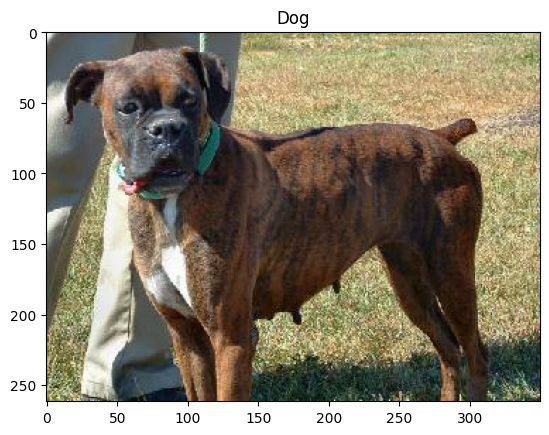

In [17]:
import matplotlib.pyplot as plt

# 훈련 데이터셋에서 하나의 데이터만 가져오기
# take는 튜플(순서쌍)을 반환하므로 ,로 첫 번째 원소만 가져옵니다.
data, = train_ds.take(1)  

# 데이터 안에는 이미지(그림)와 레이블(정답)이 기재되어 있습니다.
image = data[0]#TODO: data의 첫 번째 원소
label = data[1]#TODO: data의 두 번째 원소

# TODO: 이미지 모양 (shape) 출력해보기, 가장 마지막에 기재된 채널 수를 확인해보세요.
print(image.shape)
# TODO: 코드 한 줄로 image 그려보기 
plt.imshow(image)
# TODO: 그림 위에 title 달기 / label이 0이면 Cat, 1이면 Dog
if label == 0:
  plt.title('Cat')   
else:
  plt.title('Dog')

## TODO1: 훈련 데이터 그려보기
훈련 데이터의 첫 9장을 그려봅시다.

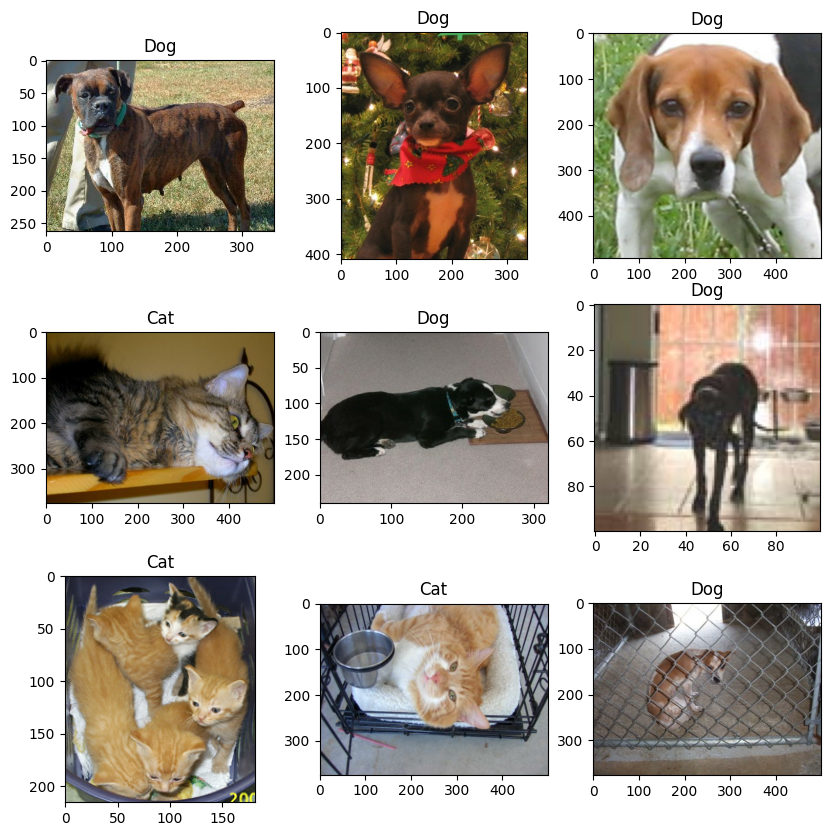

In [18]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for i, (image, label) in enumerate(train_ds.take(9)):#: take 함수로 9장 가져오세요.): 
    ax = plt.subplot(3,3,i+1) #행 3개, 열 3개, 1로 시작하는 인덱스
    # TODO: image를 그리세요.
    plt.imshow(image)
    # TODO: Cat인지 Dog인지 타이틀로 표시하세요.
    if label == 0:
      plt.title('Cat')
    else:
      plt.title('Dog')
plt.show()

## TODO2: 데이터셋 전처리하기
나중에 우리는 150 x 150 크기의 그림을 입력으로 받는 Xception 모델을 사용할 것이기 때문에<br> 그림 크기를 150 x 150으로 변환하고 Xception의 전처리 기법을 사용하겠습니다.<br>
(Xception: Keras 개발자가 Google에서 만든 합성곱 인공신경망)

In [19]:
size = (150, 150)

# train_ds의 모든 원소에 대해 람다라는 이름 없는 함수를 적용합니다.
# 각 원소는 이미지 (X)와 레이블 (y)을 순서쌍의 형태로 갖고 있는데 
# X에는 resize 함수로 이미지 크기를 변경해 반환하고 y는 그대로 반환합니다.
# 원래 이미지는 [0, 255]에 해당하는 int였는데, resize 함수는 [0, 255] float으로 타입을 바꿔줍니다.
train_ds = train_ds.map(lambda X, y: (tf.image.resize(X, size), y))
validation_ds = validation_ds.map(lambda X, y: (tf.image.resize(X, size), y))#TODO: 검증 데이터셋 변환
test_ds = test_ds.map(lambda X, y: (tf.image.resize(X, size), y))#TODO: 테스트 데이터셋 변환

In [20]:
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.applications.xception import preprocess_input

# 람다 함수를 사용해 각 데이터셋의 X (이미지)에만 preprocess_input을 적용해보세요.
# [0, 255] float이 [-1, 1] float으로 바뀝니다.
# Hint: 반환할 때 바로 위의 코드 블록과 동일하게 순서쌍의 형태 (이미지, 레이블)로 반환해야 합니다.
train_ds = train_ds.map(lambda X, y: (preprocess_input(X), y))
validation_ds = validation_ds.map(lambda X, y: (preprocess_input(X), y))
test_ds = test_ds.map(lambda X, y: (preprocess_input(X), y))



In [21]:
# 빠른 속도를 위해 데이터셋을 32장씩 묶어 준비합니다.
batch_size = 32

train_ds = train_ds.cache().batch(batch_size).prefetch(buffer_size=10)
validation_ds = validation_ds.cache().batch(batch_size).prefetch(buffer_size=10)
test_ds = test_ds.cache().batch(batch_size).prefetch(buffer_size=10)

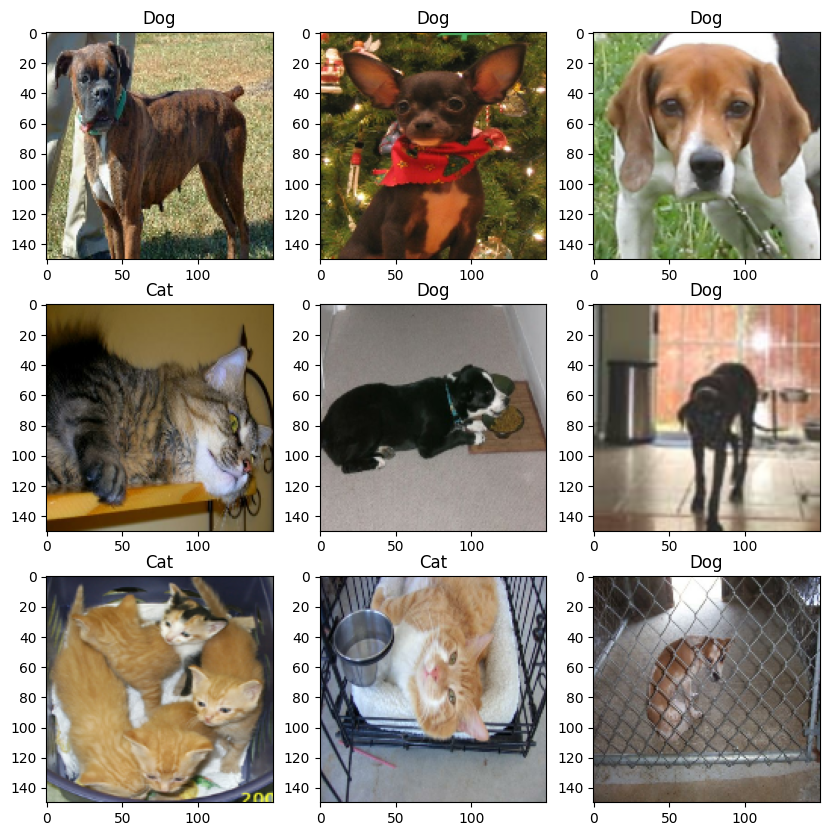

In [22]:
# 훈련 데이터 첫 9장을 그려보세요.

plt.figure(figsize=(10, 10))
batch, = train_ds.take(1) # 이제부터 1의 의미는 한 묶음 (32장) 가져오기

images, labels = batch#TODO: 한 줄로 할당해보세요. 두 줄로 하셔도 됩니다.

# TODO1의 리사이징 버전이 그려져야 합니다.
for i, image in enumerate(images[:9]):#TODO: images 첫 9장 슬라이싱하세요.): 
  plt.subplot(3, 3, i + 1)
  # matplotlib은 [0, 255] int나 [0, 1] float을 제대로 그리기 때문에 
  # 우리의 입력인 [-1, 1] float은 이상하게 그려집니다.
  # 그냥 그려봐도 되고 image에 1을 먼저 더한 후 2로 나누어서 [0, 1] float으로 그려도 됩니다. 
  # (NumPy에서는 다차원 배열의 각 원소에도 손쉽게 덧셈, 나눗셈이 가능합니다.)
  # TODO: image 그리기
  plt.imshow(np.clip((image+1)/2, 0, 1))
  # TODO: Cat/Dog title 설정하기 
  plt.title("Dog" if labels[i] else "Cat")
    
plt.show()

## TODO3: 데이터 늘리기<br>
별도의 데이터 증강 없이 딥러닝 모델에 데이터를 변환하는 층을 포함시킬 것입니다.<br>
(훈련할 때 인공신경망은 항상 원본에서 변형된 그림으로 학습합니다.)
https://www.tensorflow.org/api_docs/python/tf/keras/layers/RandomFlip
https://www.tensorflow.org/api_docs/python/tf/keras/layers/RandomRotation

In [24]:
from tensorflow import keras
from tensorflow.keras import layers

# 좌우로만 뒤집는 층과 360도의 10%만큼 시계, 반시계로 회전하는 층을 만들어보세요.
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),#TODO), #각 괄호 안에 적절한 값을 넣으셔야 합니다.
        layers.RandomRotation(0.1),#TODO), # 이 층 뒤에 계속 다른 층이 연결될 예정이라 Comma를 지우시면 안됩니다. 
    ] 
)

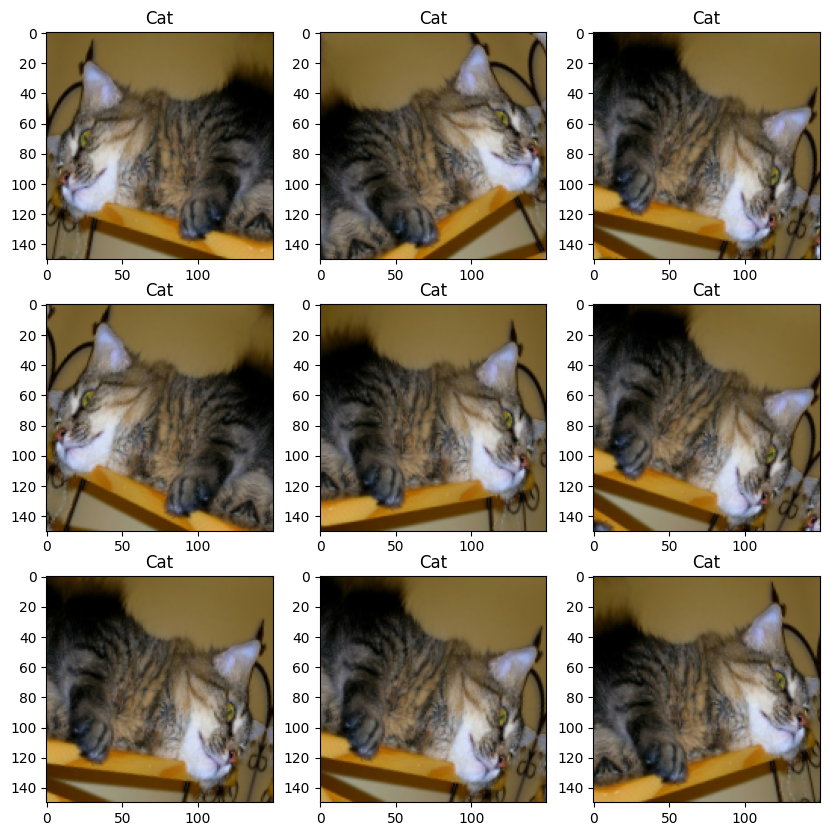

In [27]:
# 텐서에 reshape 적용 가능하게 만드는 코드
from tensorflow.python.ops.numpy_ops import np_config
np_config.enable_numpy_behavior()

# TODO: 전처리된 훈련 데이터셋(train_ds)에서 네 번째 그림 (고양이)를 가져오세요.
image = train_ds.take(1).map(lambda x, y: x[3]).as_numpy_iterator().next() # images에서 가져오시면 쉽습니다.

# TODO: 훈련 데이터의 첫 번째 그림을 데이터 증강층으로 변형하여 9장 그려보세요.
# 의도한 훈련 데이터가 생성되는지 확인하고 그렇지 않다면 데이터 증강층을 다시 만드세요.
plt.figure(figsize=(10, 10))
for i in range(9):
  plt.subplot(3, 3, i + 1)
  # 딥러닝 층으로 들어갈 때에는 (그림 인덱스, 세로, 가로, 채널)로 들어가야 합니다.
  # 현재 image는 (세로, 가로, 채널)입니다. 차원 늘리기 필요.  
  # pic에 image의 변형된 그림이 저장됩니다.
  pic = data_augmentation(tf.expand_dims(image, axis=0), training=True) # image의 차원을 늘려서 입력하세요. 차원 늘리는 함수 혹은 reshape도 가능
  
  # Q: training 옵션은 현재 훈련 중인지 아닌지를 알려주는데 증강층은 훈련할 때에만 동작합니다.
  # 즉 실전에 투입되어 모르는 그림을 인식할 때에는 동작하지 않습니다. 왜 그럴까요? (중요)
  # A:

  # 변형된 그림을 그리기 위해 의미 없이 늘린 차원 다시 줄이기 
  pic = tf.squeeze(pic)
  # TODO: pic을 그려보세요. 
  plt.imshow((pic + 1) / 2)
  plt.title("Cat")
plt.show()  

## TODO4: 모델 정의하기<br>
클래스가 0 (고양이)와 1 (개) 밖에 없으므로 loss는 binary_crossentropy를 사용합니다.<br>
입력은 (150, 150, 3), 마지막 출력층은 노드가 하나입니다. (0이면 고양이, 1이면 개)<br>
출력은 하나의 노드에서 0 또는 1이므로 출력층의 활성화 함수는 softmax 대신 sigmoid 등을 사용해야 합니다.<br>
softmax는 여러 개 중에서 무엇을 선택할까인데 여기에 사용하면 무조건 하나의 출력 노드를 1로 만듭니다.<br>
sigmoid (S자형 곡선)의 경우에는 0과 1사이의 값을 출력합니다. (Cats vs. Dogs)<br>
그 외에는 자유롭게 만드세요. (Conv2D 층은 꼭 사용하시기 바랍니다.)

In [28]:
from keras import models
from keras import layers
from keras.callbacks import EarlyStopping

model = models.Sequential()

# TODO: 입력층
model.add(layers.Input(shape=(150, 150, 3)))

# 데이터 증강층
model.add(data_augmentation) #TODO: 위에서 만든 데이터 증강층을 넣으세요.

# 자유롭게 설정
model.add(layers.Conv2D(32, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(512, activation='relu'))
# 출력층
model.add(layers.Dense(1,'sigmoid' )) # TODO: 노드 수와 활성화 함수 기재 (softmax 사용 금지)
    
# 컴파일
model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=["accuracy"])

In [29]:
# 훈련해야 하는 파라미터가 몇 개인지 확인해보세요.
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 150, 150, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 74, 74, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 36, 36, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 34, 34, 128)      

## TODO5: 모델 훈련

In [30]:
# validation_ds도 제공하여 테스트 데이터에 대한 성능도 가늠해보세요. 
# (validation_split 대신 validation_data= 사용)
# 데이터셋 사용시에는 X(그림)와 y(정답)을 따로 넣을 필요 없이 train_ds만 입력하면 됩니다.
# 여기에서 너무 많은 시간을 사용하지 마세요. (정확도 70% 이상, 30분 이내 완료 추천)

from keras.callbacks import EarlyStopping

epochs = 10000
es = EarlyStopping(patience=10, restore_best_weights=True)
model.fit(train_ds, validation_data=validation_ds, epochs=epochs, callbacks=es)

Epoch 1/10000
291/291 [==============================] - 30s 61ms/step - loss: 0.6628 - accuracy: 0.5934 - val_loss: 0.5822 - val_accuracy: 0.7068
Epoch 2/10000
291/291 [==============================] - 9s 30ms/step - loss: 0.5912 - accuracy: 0.6831 - val_loss: 0.5257 - val_accuracy: 0.7476
Epoch 3/10000
291/291 [==============================] - 9s 30ms/step - loss: 0.5347 - accuracy: 0.7402 - val_loss: 0.4910 - val_accuracy: 0.7584
Epoch 4/10000
291/291 [==============================] - 8s 29ms/step - loss: 0.4986 - accuracy: 0.7567 - val_loss: 0.4523 - val_accuracy: 0.7936
Epoch 5/10000
291/291 [==============================] - 9s 30ms/step - loss: 0.4667 - accuracy: 0.7793 - val_loss: 0.4280 - val_accuracy: 0.8083
Epoch 6/10000
291/291 [==============================] - 8s 28ms/step - loss: 0.4379 - accuracy: 0.7958 - val_loss: 0.4232 - val_accuracy: 0.7915
Epoch 7/10000
291/291 [==============================] - 9s 29ms/step - loss: 0.4096 - accuracy: 0.8136 - val_loss: 0.3916 

## TODO6: 테스트 데이터로 평가하기
정확도 70% 이상을 노리지만 30분 이상의 시간을 사용했다면 다음 노트북으로 넘어갑니다.

In [32]:
# 평가해보세요.
model.evaluate(test_ds)

73/73 [==============================] - 1s 13ms/step - loss: 0.2261 - accuracy: 0.9162


[0.22609205543994904, 0.9161651134490967]